In [155]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results_dir = '../../results/shuffle_experiment/default'

sns.set_style("darkgrid")

def draw_checkpoint_line(ax, df_model_results, palette, linestyles):
    for idx_exp, experiment in enumerate(df_model_results['Experiment'].unique()):
        df_experiment = df_model_results[df_model_results['Experiment'] == experiment]
        df_experiment = df_experiment.sort_values(by='Experiment')

        ax.axvline(x=df_experiment['Epoch'].iloc[0], color=palette[idx_exp], linestyle=linestyles[idx_exp], linewidth=1)


def plot_loss_curves(df_losses, palette=sns.color_palette("tab10")):
    models = df_losses['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(ncols=2,nrows=len(models), figsize=(12, 6*len(models)), sharex=True, sharey=True)

    for idx, m in enumerate(models):
        df_model = df_losses[df_losses['Model'] == m]
        df_model = df_model.sort_values(by='Experiment')

        sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
        sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
        ax[idx, 0].set(title=f'Train Loss - {m}', ylabel='BCE Loss')
        ax[idx,1].set(title=f'Validation Loss - {m}')

    plt.tight_layout()
    
    return fig


def plot_auroc_curves(df, df_results=None, palette=sns.color_palette("tab10"), linestyles = ['-.','--',':']):
    models = df['Model'].unique()
    if len(models) == 0:
        raise ValueError("No models found in the DataFrame.")
    
    fig, ax = plt.subplots(figsize=(12, 6), sharex=True, sharey=True, ncols=len(models))

    metric_name =  df.iloc[0]['metric']

    for idx, m in enumerate(models):
        df_model = df[df['Model'] == m]
        sns.lineplot(data=df_model, x='Epoch', y='val_metric', hue='Experiment', ax=ax[idx])
        ax[idx].set(title=f'Validation {metric_name} - {m}', ylabel=metric_name)

        if df_results is not None:
            df_model_results = df_results[df_results['Model'] == m]
            draw_checkpoint_line(ax[idx], df_model_results, palette, linestyles)

    plt.tight_layout()

    return fig

def plot_all_auroc_curves(df_losses):
    sns.set_palette("tab10")
    sns.set_style("dark")

    models = df_losses['Model'].unique()
    tasks = df_losses['Task'].unique()

    fig, ax = plt.subplots(figsize=(3*len(models)+3, 3*len(tasks)), sharex=True, sharey=True, ncols=len(models), nrows=len(tasks))

    for idx, t in enumerate(tasks):
        metric_name =  df_losses[df_losses['Task'] == t].iloc[0]['metric']

        for jdx, m in enumerate(models):
            df_model = df_losses[(df_losses['Model'] == m) & (df_losses['Task'] == t)]

            sns.lineplot(data=df_model, x='Epoch', y='val_metric', hue='Experiment', ax=ax[idx, jdx])
            ax[idx, jdx].set_ylabel(metric_name)

    for idx, a in enumerate(ax[0,:]):
        a.set_title(f'{models[idx]}')

    for idx, a in enumerate(ax[:,0]):
        ax_double = a.twinx()
        ax_double.yaxis.set_label_position("left")
        ax_double.spines['left'].set_position(('axes', -0.4))
        ax_double.spines['left'].set_visible(False)
        ax_double.set_ylabel(f'{tasks[idx]}', ha='right', va='center', rotation=0)
        ax_double.set_yticks([])

    plt.tight_layout()

def print_test_results(df):
    print(df[['Task', 'Experiment', 'Model','Epoch','test_loss','test_auroc_avg']].sort_values(by='test_auroc_avg', ascending=False).to_markdown(index=False, floatfmt=".3f"))


In [156]:
def read_results(experiment_path, model,df_filename):
    df = pd.read_csv(os.path.join(experiment_path, model, df_filename))
    splits = experiment.split('_')
    task = splits[0] + ' ' + splits[1]
    df['Task'] = task
    df['Experiment'] = splits[-1] if len(splits) > 2 else 'default'
    df['Model'] = model

    df['criterion'] = 'CE' if task == 'gene finding' else 'BCE'


    val_results_col, metric_name = 'val_auroc', 'AUROC'
    if task == 'gene finding':
        val_results_col, metric_name = 'val_mcc', 'MCC'
    if task == 'enhancer annotation':
        val_results_col, metric_name = 'val_auprc', 'AUPRC'

    df.rename(columns={val_results_col: 'val_metric'}, inplace=True)
    df['metric'] = metric_name

    return df

dfs_losses = []
dfs_tests = []

for experiment in os.listdir(results_dir):
    if experiment.startswith('.'):
        continue

    print(f'Processing {experiment}...')
    experiment_path = os.path.join(results_dir, experiment)
    for model in os.listdir(experiment_path):
        if model.startswith('.'):
            continue
        print(f'\t Processing {model}...')
        
        if 'losses.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_losses.append(read_results(experiment_path, model,'losses.csv'))

        if 'best_model_metrics.csv' in os.listdir(os.path.join(experiment_path, model)):
            dfs_tests.append(read_results(experiment_path, model,'best_model_metrics.csv'))

df_losses = pd.concat(dfs_losses, ignore_index=True)
df_tests = pd.concat(dfs_tests, ignore_index=True)       

Processing gene_finding_shuffled...
	 Processing hyenadna-tiny-1k...
Processing chromatin_accessibility...
	 Processing hyenadna-tiny-1k...
Processing gene_finding...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing histone_modification_shuffled...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing cpg_methylation_shuffled...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing enhancer_annotation...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing chromatin_accessibility_shuffled...
	 Processing hyenadna-tiny-1k...
Processing histone_modification...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing cpg_methylation...
	 Processing resnetlm...
	 Processing hyenadna-tiny-1k...
	 Processing dnabert2...
Processing histone_modification_1 worker...
	 Processing hyenadna-tiny-1k

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/3714021675.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_losses = pd.concat(dfs_losses, ignore_index=True)


In [157]:
df_losses_hyenadna = df_losses[df_losses['Model'] == 'hyenadna-tiny-1k']
df_tests_hyenadna = df_tests[df_tests['Model'] == 'hyenadna-tiny-1k']

In [158]:
df_losses = df_losses[~df_losses['Experiment'].str.contains('1 worker')]
df_losses

,Epoch,train_loss,val_loss,val_metric,training_time,Task,Experiment,Model,criterion,metric
0,1,1.541721,1.408060,0.030714,483.927838,gene finding,shuffled,hyenadna-tiny-1k,CE,MCC
1,2,1.388136,1.384322,0.032441,207.826620,gene finding,shuffled,hyenadna-tiny-1k,CE,MCC
2,3,1.370484,1.368925,0.049658,203.106482,gene finding,shuffled,hyenadna-tiny-1k,CE,MCC
3,4,1.360315,1.360305,0.047095,204.788136,gene finding,shuffled,hyenadna-tiny-1k,CE,MCC
4,5,1.354346,1.356091,0.046461,204.030271,gene finding,shuffled,hyenadna-tiny-1k,CE,MCC
...,...,...,...,...,...,...,...,...,...,...
1902,96,0.200744,0.328340,0.878281,10058.681041,cpg methylation,default,dnabert2,BCE,AUROC
1903,97,0.199446,0.324222,0.880634,10094.692307,cpg methylation,default,dnabert2,BCE,AUROC
1904,98,0.199119,0.322654,0.879572,10051.430085,cpg methylation,default,dnabert2,BCE,AUROC
1905,99,0.199459,0.336544,0.875524,9926.452186,cpg methylation,default,dnabert2,BCE,AUROC


In [159]:
df_tests = df_tests[~df_tests['Experiment'].str.contains('1 worker')]
df_tests

,Epoch,train_loss,val_loss,val_metric,training_time,test_loss,test_mcc,test_recall_0,test_recall_1,test_recall_2,...,test_auroc_116,test_auroc_117,test_auroc_118,test_auroc_119,test_auroc_120,test_auroc_121,test_auroc_122,test_auroc_123,test_auroc_124,test_auprc
0,98.0,1.305766,1.317237,0.114013,210.513484,1.318288,0.120038,0.053829,0.001847,0.265169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95.0,0.234573,0.227144,0.793160,1883.205509,0.241301,NaN,NaN,NaN,NaN,...,0.756507,0.771665,0.780191,0.803064,0.748799,0.721466,0.735937,0.795427,0.769094,NaN
2,82.0,1.002696,1.013157,0.368422,391.972230,1.029563,0.372700,0.561848,0.319483,0.533877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100.0,1.302535,1.309338,0.112771,213.739138,1.315342,0.114601,0.064022,0.018467,0.488433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,0.957122,0.974381,0.435961,646.839210,0.981134,0.430381,0.500500,0.120037,0.572284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,19.0,0.253326,0.240857,0.790121,1400.757037,0.254662,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,94.0,0.257448,0.244612,0.778233,713.894150,0.256740,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8.0,0.256876,0.244331,0.780911,1615.820260,0.256145,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,50.0,0.189056,0.237416,0.915059,10906.271173,0.247636,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100.0,0.228064,0.253988,0.900813,5458.450014,0.271021,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## HyenaDNA

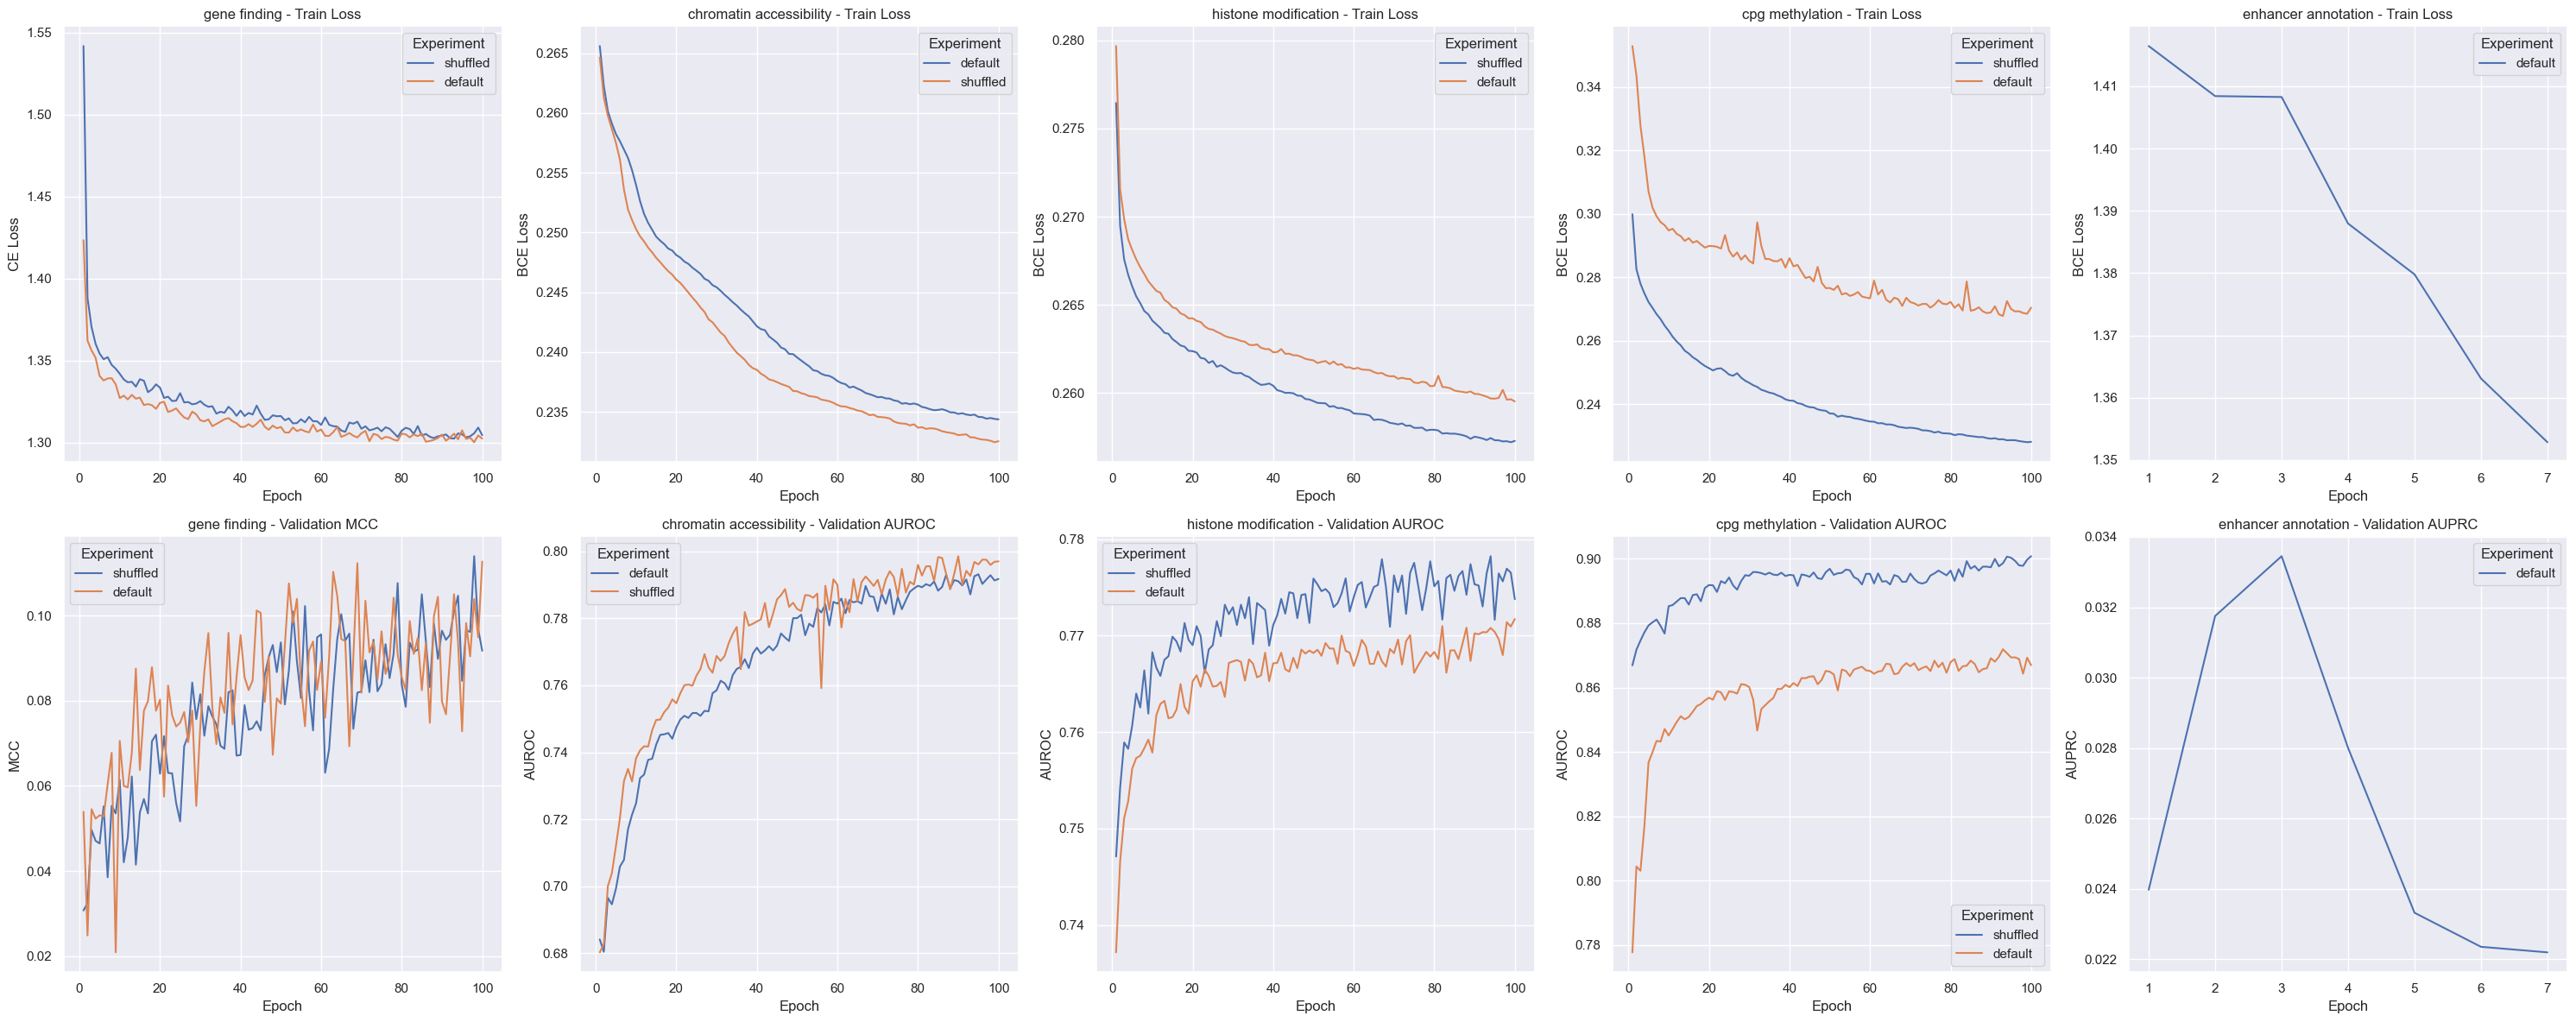

In [170]:
tasks =  df_losses_hyenadna['Task'].unique()

fig, ax = plt.subplots(ncols=len(tasks),nrows=2, figsize=(6*len(tasks),12), sharex=False, sharey=False)

for idx, t in enumerate(tasks):

    df_model = df_losses_hyenadna[(df_losses_hyenadna['Task'] == t) & (df_losses_hyenadna['Experiment'] != '1 worker')]

    sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', ax=ax[0, idx])
    sns.lineplot(data=df_model, x='Epoch', y='val_metric', hue='Experiment', ax=ax[1, idx])
    ax[0, idx].set(title=f'{t} - Train Loss', ylabel=f'{df_model["criterion"].iloc[0]} Loss')
    ax[1, idx].set(title=f'{t} - Validation {df_model["metric"].iloc[0]}', ylabel=df_model['metric'].iloc[0])

plt.tight_layout()


In [161]:
df_losses_hyenadna['Experiment'].unique()

array(['shuffled', 'default', '1 worker'], dtype=object)

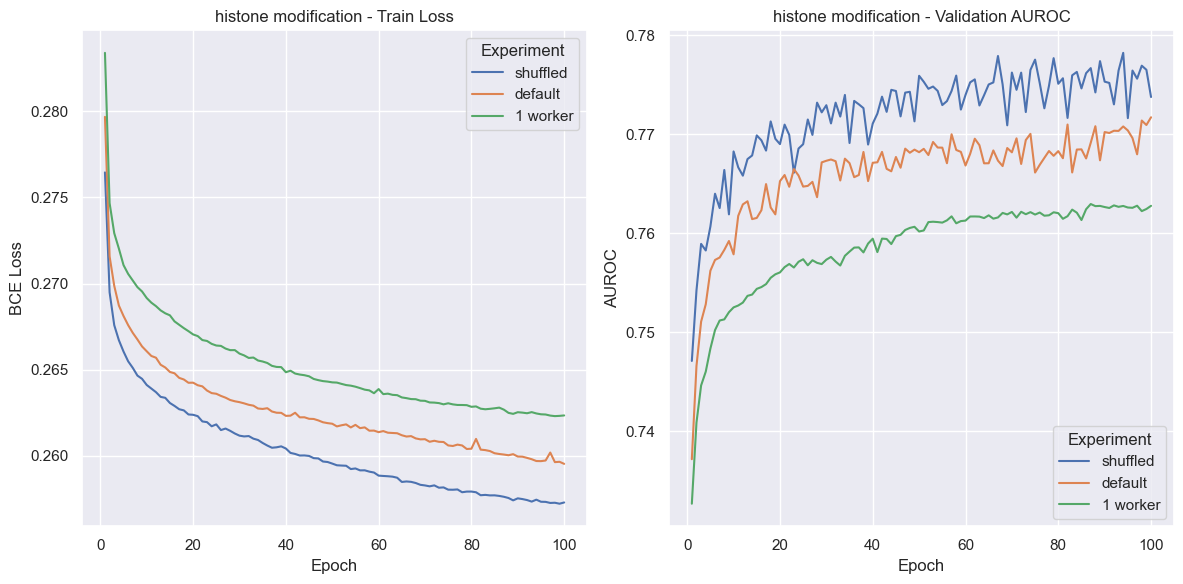

In [171]:
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(12,6), sharex=False, sharey=False)

palette = sns.color_palette("tab10")

t = 'histone modification'
    
df_model = df_losses_hyenadna[df_losses_hyenadna['Task'] == t]

sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', ax=ax[0])
sns.lineplot(data=df_model, x='Epoch', y='val_metric', hue='Experiment', ax=ax[1])
ax[0].set(title=f'{t} - Train Loss', ylabel=f'{df_model["criterion"].iloc[0]} Loss')
ax[1].set(title=f'{t} - Validation {df_model["metric"].iloc[0]}', ylabel=df_model['metric'].iloc[0])

plt.tight_layout()

## CpG Methylation

In [163]:
df_cpg = df_losses[df_losses['Task'] == 'cpg methylation']
df_cpg

,Epoch,train_loss,val_loss,val_metric,training_time,Task,Experiment,Model,criterion,metric
800,1,0.273666,0.265990,0.887118,11185.061165,cpg methylation,shuffled,resnetlm,BCE,AUROC
801,2,0.252986,0.254817,0.903391,11017.207081,cpg methylation,shuffled,resnetlm,BCE,AUROC
802,3,0.240614,0.244107,0.909345,11003.908748,cpg methylation,shuffled,resnetlm,BCE,AUROC
803,4,0.234398,0.243757,0.910577,11221.629020,cpg methylation,shuffled,resnetlm,BCE,AUROC
804,5,0.230006,0.241715,0.911931,10937.400368,cpg methylation,shuffled,resnetlm,BCE,AUROC
...,...,...,...,...,...,...,...,...,...,...
1902,96,0.200744,0.328340,0.878281,10058.681041,cpg methylation,default,dnabert2,BCE,AUROC
1903,97,0.199446,0.324222,0.880634,10094.692307,cpg methylation,default,dnabert2,BCE,AUROC
1904,98,0.199119,0.322654,0.879572,10051.430085,cpg methylation,default,dnabert2,BCE,AUROC
1905,99,0.199459,0.336544,0.875524,9926.452186,cpg methylation,default,dnabert2,BCE,AUROC


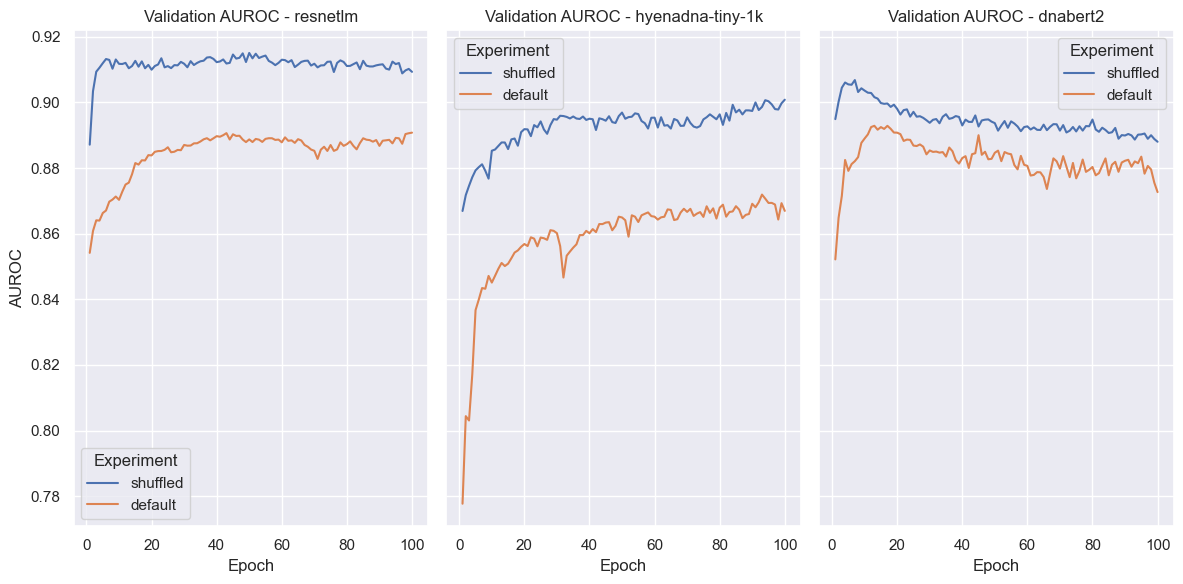

In [164]:
fig = plot_auroc_curves(df_cpg)

## Histone Modification

In [165]:
df_losses_histone = df_losses[df_losses['Task'] == 'histone modification']
df_tests_histone = df_tests[df_tests['Task'] == 'histone modification']

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/3918363014.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/3918363014.py:31: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='val_loss', hue='Experiment', palette=palette, ax=ax[idx,1])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/3918363014.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(data=df_model, x='Epoch', y='train_loss', hue='Experiment', palette=palette, ax=ax[idx,0])
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/3918363014.py:31: UserWarning: The palette list has more values (10) than needed (2),

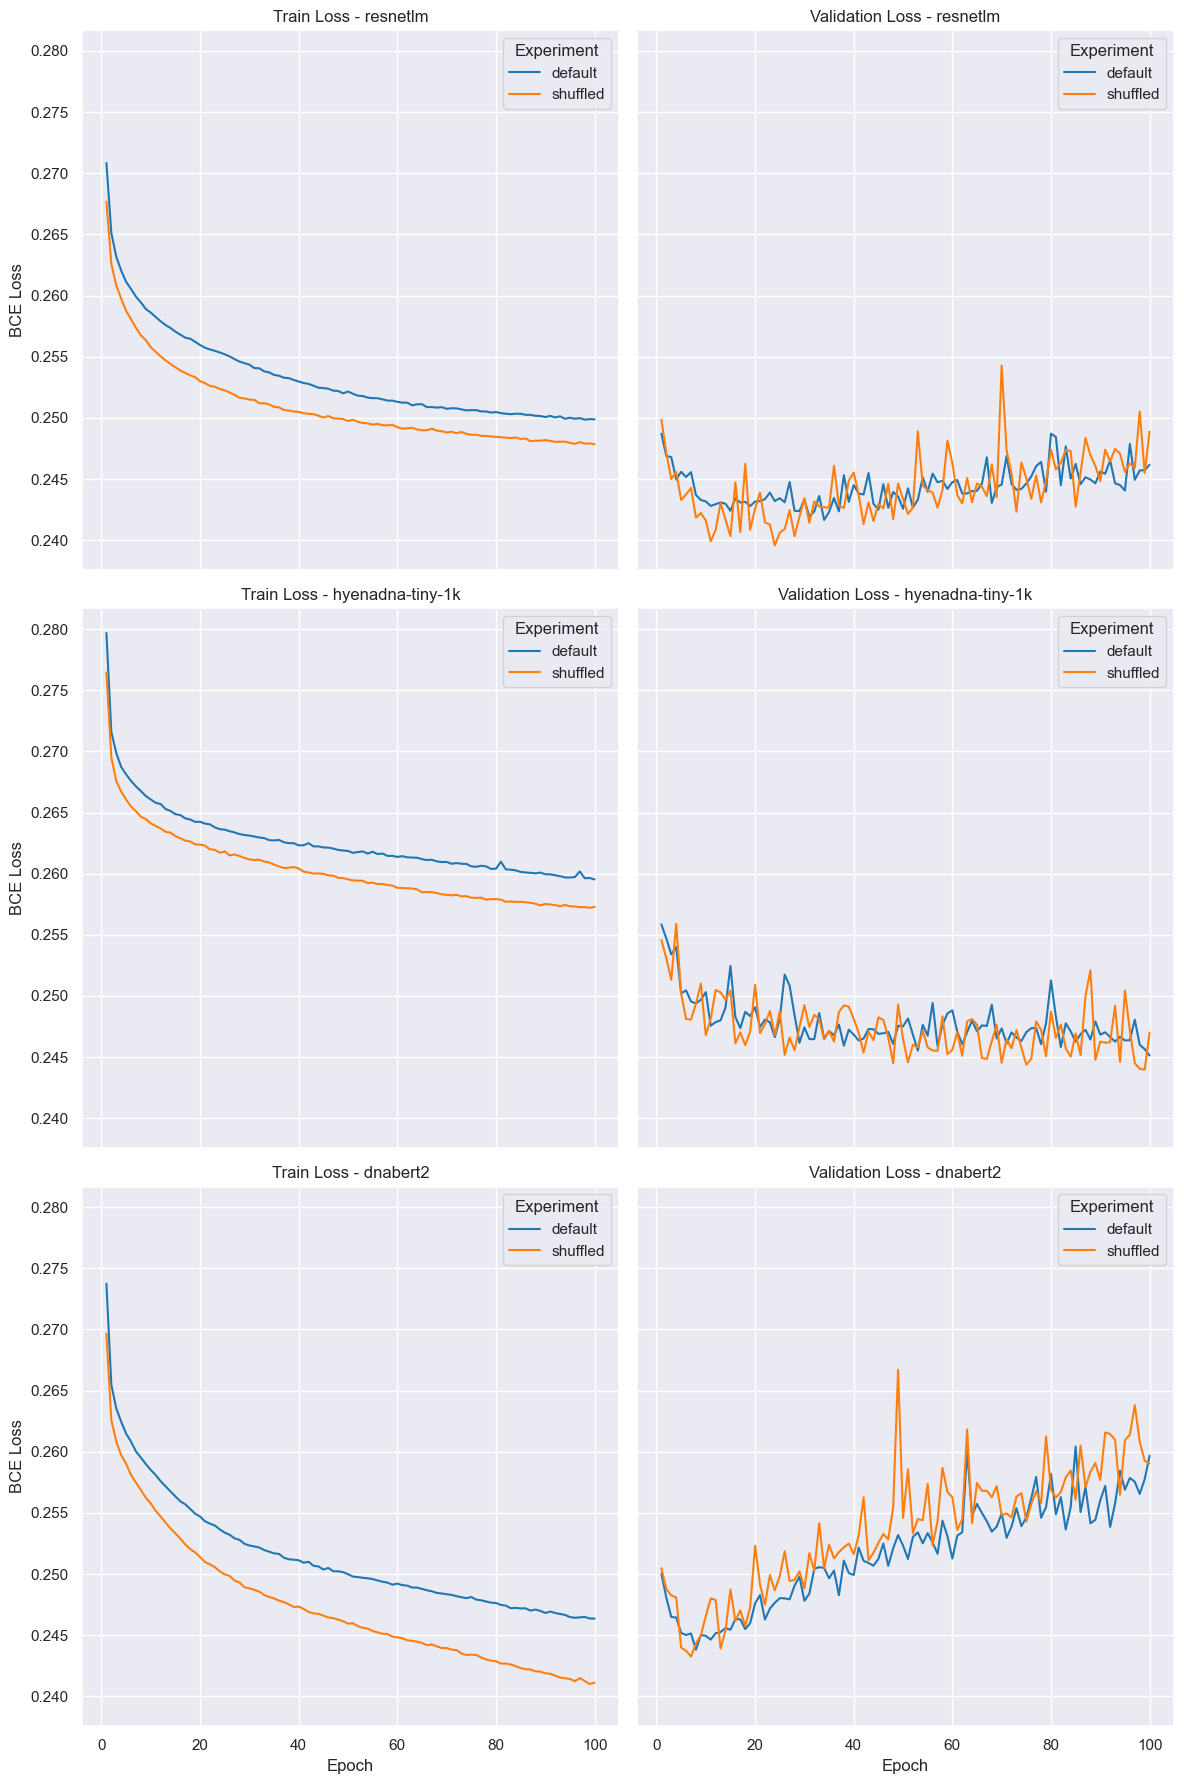

In [166]:
fig = plot_loss_curves(df_losses_histone)
# plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on CpG Methylation Task')
# plt.savefig(f'losses_{MODEL}.png', dpi=300)

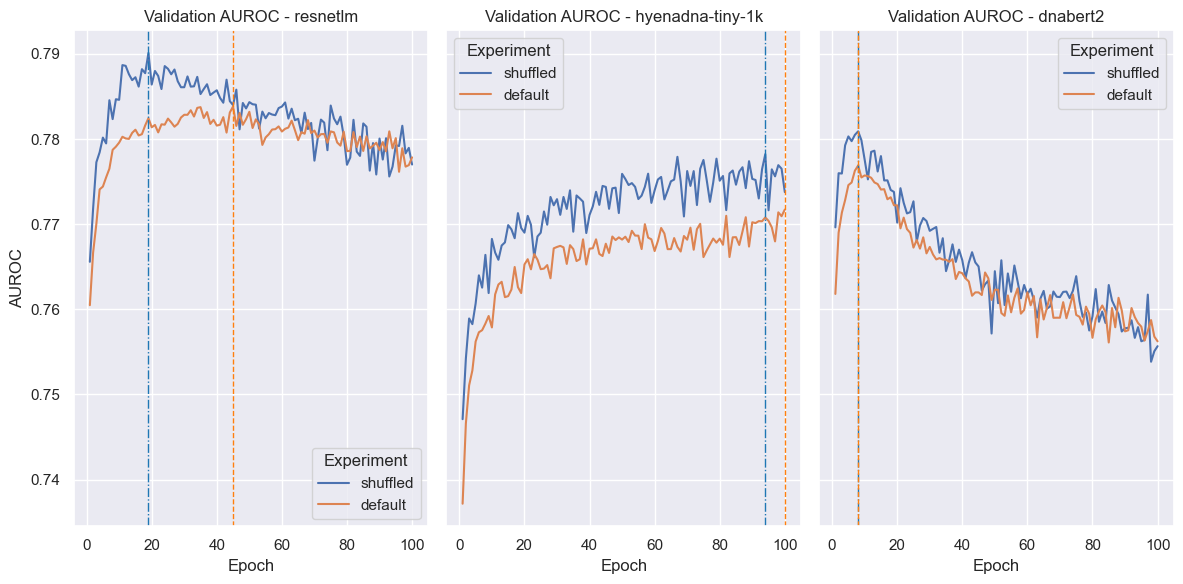

In [167]:
fig = plot_auroc_curves(df_losses_histone, df_tests_histone)
# plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on CpG Methylation Task')
# plt.savefig(f'val_AUROC_{MODEL}.png', dpi=300)

In [168]:
print_test_results(df_tests_histone)

| Task                 | Experiment   | Model            |   Epoch |   test_loss |   test_auroc_avg |
|:---------------------|:-------------|:-----------------|--------:|------------:|-----------------:|
| histone modification | shuffled     | resnetlm         |  19.000 |       0.255 |            0.785 |
| histone modification | default      | resnetlm         |  45.000 |       0.255 |            0.780 |
| histone modification | shuffled     | dnabert2         |   8.000 |       0.256 |            0.776 |
| histone modification | default      | dnabert2         |   8.000 |       0.257 |            0.773 |
| histone modification | shuffled     | hyenadna-tiny-1k |  94.000 |       0.257 |            0.772 |
| histone modification | default      | hyenadna-tiny-1k | 100.000 |       0.258 |            0.766 |


## Training Times

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/833402340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_losses['training_time_mins'] = df_losses['training_time']/60
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/833402340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_losses['training_time_hours'] = df_losses['training_time_mins']/60
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_26608/833402340.py:6: SettingWithCopyWarning: 
A value is trying 

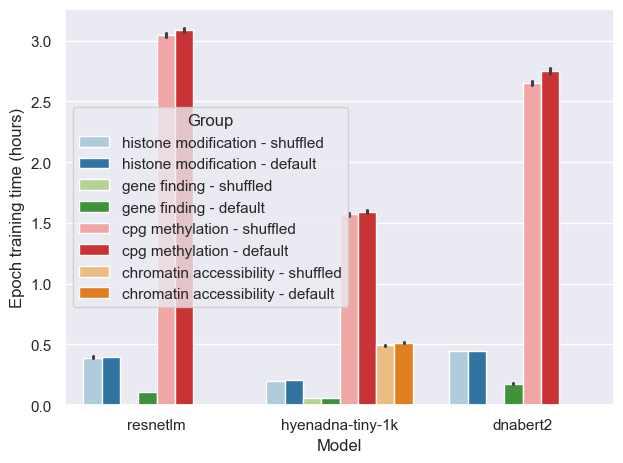

In [169]:
df_losses = df_losses[df_losses['Task'] != 'enhancer annotation']

df_losses['training_time_mins'] = df_losses['training_time']/60
df_losses['training_time_hours'] = df_losses['training_time_mins']/60

df_losses['Group'] = df_losses['Task'] + ' - ' + df_losses['Experiment']
df_losses.sort_values(by=['Task', 'Experiment'], ascending=False, inplace=True)
sns.barplot(data=df_losses, x='Model', y='training_time_hours', hue='Group', palette=sns.color_palette('Paired'))

plt.ylabel('Epoch training time (hours)')
plt.tight_layout()
# plt.show()

## Histone HyenaDNA

The Histone DNA task uses 32 workers as default, which impact the level of shufflying.
Hence, we run the histone modification task using 1 worker and the hyenadna-tiny-1k model.

Text(0.5, 0.98, 'Train and Validation Losses of HyneaDNA-tiny-1k on Histone Modification Task')

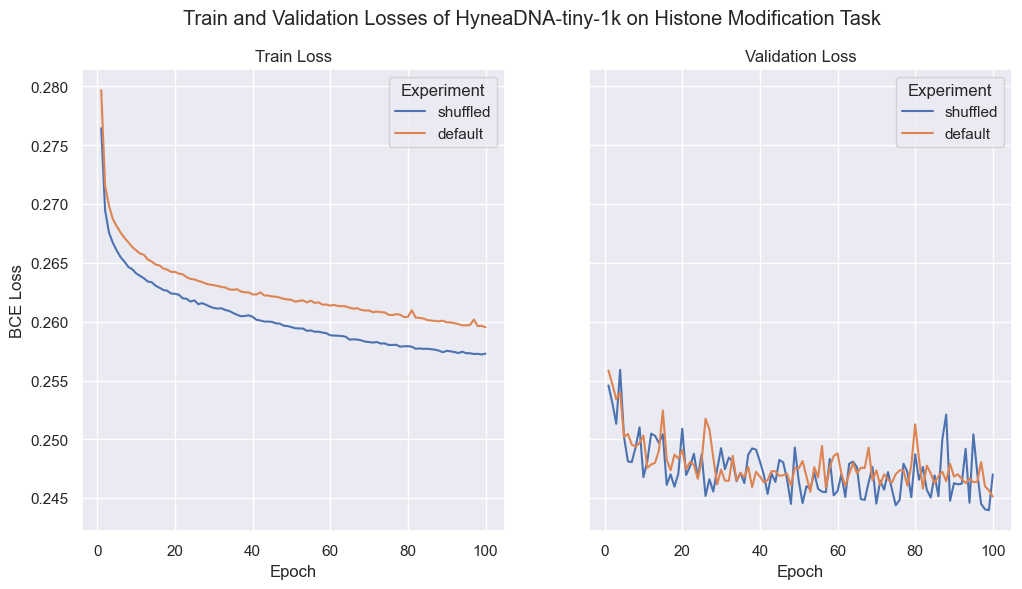

In [48]:
df_hyenadna = df_losses_hyenadna[df_losses_hyenadna['Task'] == 'histone modification']

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=False, sharey=True)

sns.lineplot(data=df_hyenadna, x='Epoch', y='train_loss', hue='Experiment', ax=ax[0])
sns.lineplot(data=df_hyenadna, x='Epoch', y='val_loss', hue='Experiment', ax=ax[1])
ax[0].set(title='Train Loss', ylabel='BCE Loss')
ax[1].set(title='Validation Loss')
plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on Histone Modification Task')

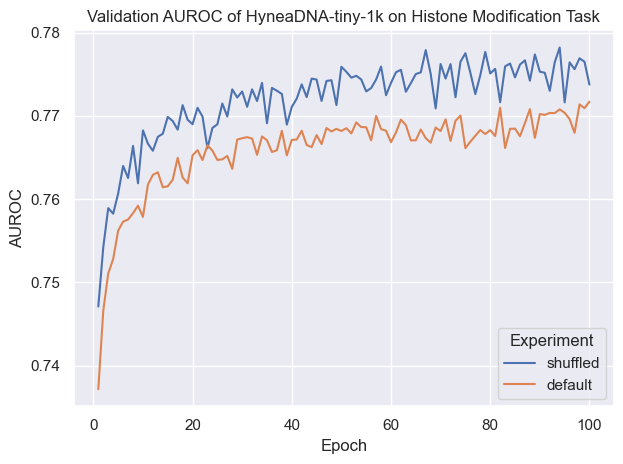

In [49]:
sns.lineplot(data=df_hyenadna, x='Epoch', y='val_auroc', hue='Experiment')

plt.ylabel('AUROC')
plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on Histone Modification Task')
plt.tight_layout()

In [50]:
print_test_results(df_tests_hyenadna)

| Task                    | Experiment   | Model            |   Epoch |   test_loss |   test_auroc_avg |
|:------------------------|:-------------|:-----------------|--------:|------------:|-----------------:|
| cpg methylation         | shuffled     | hyenadna-tiny-1k | 100.000 |       0.271 |            0.900 |
| cpg methylation         | default      | hyenadna-tiny-1k |  93.000 |       0.304 |            0.868 |
| chromatin accessibility | shuffled     | hyenadna-tiny-1k |  90.000 |       0.237 |            0.803 |
| chromatin accessibility | default      | hyenadna-tiny-1k |  95.000 |       0.241 |            0.798 |
| histone modification    | shuffled     | hyenadna-tiny-1k |  94.000 |       0.257 |            0.772 |
| histone modification    | default      | hyenadna-tiny-1k | 100.000 |       0.258 |            0.766 |
| gene finding            | shuffled     | hyenadna-tiny-1k |  98.000 |       1.318 |          nan     |
| gene finding            | default      | hyenadna-tin